## Cliff walking example, comparing off-policy Q-learning and on-policy SARSA

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

%matplotlib inline 

In [2]:
np.random.seed(2025)

n_rows = 4
n_cols = 12

gridworld = np.zeros((n_rows, n_cols))
gridworld[3, 0] = 1     # start
gridworld[3, -1] = 2    # end 
gridworld[3, 1:-1] = -1 # cliff 

In [3]:
gridworld

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  2.]])

In [4]:
def transition(s, a): 
    """
    from state s, take action a, return s' 

    Arguments:
        s: int tuple, (row, col)
        a: str, 'l', 'r', 'u', 'd'
    Returns
        s_prime: int tuple 
    """

    x, y = s 

    if a == 'u':
        s_prime = (np.max([x-1, 0]), y)
    elif a == 'd':
        s_prime = (np.min([x+1, n_rows-1]), y)
    elif a == 'l':
        s_prime = (x, np.max([y-1, 0]))
    elif a == 'r':
        s_prime = (x, np.min([y+1, n_cols-1]))
    
    return s_prime

In [5]:
s_prime = transition((3, 3), 'd')
print(s_prime)

(3, 3)


In [6]:
def reward(s):
    if gridworld[s] == -1:
        r = -100 
    else:
        r = -1 
    
    return r 

In [7]:
actions = ['u', 'd', 'l', 'r']
epsilon = 0.1

In [8]:
def choose_action(s):
    randnum = np.random.rand()
    if randnum < epsilon:
        aI = np.random.choice(len(actions))
    else:
        vals = Qs[s] 
        aI = np.random.choice([action_ for action_, value_ in enumerate(vals) if value_ == np.max(vals)])
    return aI 

In [21]:
# Q-learning 

n_episodes = 1000
alpha = 0.1
sum_of_rewards = [] 
n_runs = 10 

for runI in np.arange(n_runs):
    rewards_this_run = [] 
    Qs = {(r, c):np.zeros(len(actions)) for r in np.arange(n_rows) for c in np.arange(n_cols)}

    for epiI in np.arange(n_episodes):
        s = (n_rows-1, 0)
        sum_r = 0 
        while gridworld[s] != 2:
            aI = choose_action(s) 
            a = actions[aI] 
            s_prime = transition(s, a) 
            r = reward(s_prime)

            Qs[s][aI] = Qs[s][aI] + alpha * (r + np.max(Qs[s_prime]) - Qs[s][aI])
            sum_r += r 

            if gridworld[s_prime] == -1: 
                s = (n_rows-1, 0)
            else:
                s = s_prime

        rewards_this_run.append(sum_r)
    sum_of_rewards.append(np.array(rewards_this_run))

In [22]:
Qs 

{(0, 0): array([-11.61582496, -11.54176272, -11.55292001, -11.57588257]),
 (0, 1): array([-11.04014246, -11.16155637, -11.04282284, -11.05244043]),
 (0, 2): array([-10.39588798, -10.44653527, -10.43666909, -10.38044961]),
 (0, 3): array([-9.65743257, -9.64866827, -9.70505121, -9.65377821]),
 (0, 4): array([-8.85307932, -8.88384044, -8.95436662, -8.84659123]),
 (0, 5): array([-8.0611834 , -8.0658789 , -8.1149384 , -8.03803958]),
 (0, 6): array([-7.19112455, -7.27367461, -7.35012516, -7.20330808]),
 (0, 7): array([-6.37761383, -6.40634414, -6.51727957, -6.36638569]),
 (0, 8): array([-5.57228512, -5.51799095, -5.73066603, -5.50024682]),
 (0, 9): array([-4.67224682, -4.65613515, -4.83465482, -4.66129364]),
 (0, 10): array([-3.85773505, -3.82187996, -3.81611836, -3.82279158]),
 (0, 11): array([-3.        , -2.96036387, -3.1397166 , -2.97655086]),
 (1, 0): array([-12.05978165, -12.09240048, -12.16254543, -12.09128523]),
 (1, 1): array([-11.42039668, -11.38839574, -11.53091967, -11.40267451])

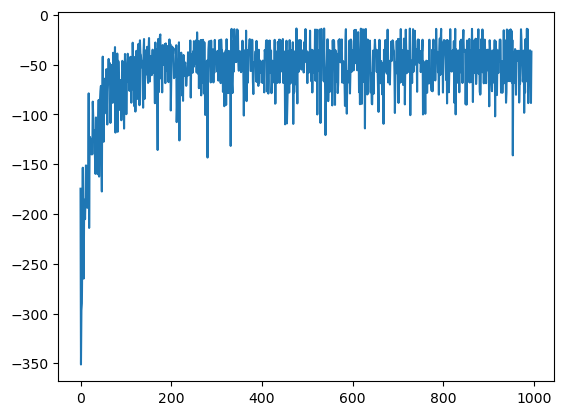

In [23]:
sum_of_rewards = np.array(sum_of_rewards)

plt.plot(sum_of_rewards.mean(axis=0)[5:])
plt.show() 

In [ ]:
def q_learning(env, ep, gamma, alpha, eps):
    """Q-Learning (off-policy TD control)
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha - step size (0..1]
        eps - epsilon-greedy param
    """
    def policy(st, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand([Q[st,a] for a in env.act_space])
        else:
            return np.random.choice(env.act_space)
    
    Q = defaultdict(float)  # default zero for all, terminal MUST be zero
    
    for _ in range(ep):
        S = env.reset()
        while True:
            A = policy(S, Q, eps)
            S_, R, done = env.step(A)
            max_Q = np.max([Q[S_,a] for a in env.act_space])
            Q[S,A] = Q[S,A] + alpha * (R + gamma * max_Q - Q[S,A])
            S = S_
            if done: break
                            
    return Q

In [ ]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

In [ ]:
class CliffWalkingEnv:
    def __init__(self):
        self.act_space = [0, 1, 2, 3]  # LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
        self.reset()
        
    def reset(self):
        self._x, self._y = 0, 0        # agent initial position
        return (0, 0)
        
    def step(self, action):
        """actions: LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3"""
        self._x, self._y = self.transition(self._x, self._y, action)
        
        if self._x in range(1,11) and self._y == 0:  # CLIFF spanning x=[1..10]
            self._x, self._y = 0, 0                  #  teleport to start
            return (self._x, self._y), -100, False   #  return -100 reward
        if self._x == 11 and self._y == 0:           # GOAL at (11,0)
            return (self._x, self._y), -1, True      #  -1, terminate
        return (self._x, self._y), -1, False         # NORMAL states
        
    def transition(self, x, y, action):
        """Perform transition from [x,y] given action. Does not teleport."""
        
        if action == 0:    x -= 1     # left
        elif action == 1:  y -= 1     # down
        elif action == 2:  x += 1     # right
        elif action == 3:  y += 1     # up
        else: raise ValueError('Action must be in [0,1,2,3]')
            
        x = np.clip(x, 0, 11)   # x range is [0..11] incl.
        y = np.clip(y, 0, 3)    # y range is [0..3] incl.
        return x, y
    
    def get_path(self, Q):
        """Returns a path agent would take, if following greedy Q-based policy"""
        x, y = 0, 0       # agent starting position
        path = [(x, y)]   # save starting position
        for _ in range(100):  # limit steps in case policy is loopy
            A_star = np.argmax([Q[(x,y),a] for a in [0, 1, 2, 3]])   # pick best action
            x, y = self.transition(x, y, A_star)         # take one step
            path.append((x,y))                           # save to path
            if x in range(1,11) and y == 0:              # CLIFF
                path.append((0, 0))                      # teleport
            if x == 11 and y == 0:  break                # GOAL at (11,0)
        return path